## BnB DFS ##

In [1]:
import numpy as np
import random 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# pg 182

def DFS(dist_mat, start, heuristic = "NN", n_clusters = 3):
    
    # cluster: create subproblems
    def cluster_heuristic(state, max_iter = 10**6, X_0 = 0.8):
        
        full_nodes = [i for i in range(N)] # full node list

        # cluster on unexpanded nodes
        unexpanded_nodes = [i for i in full_nodes if i not in state] # nodes left to explore
        unexpanded_matrix = dist_mat.take(unexpanded_nodes, axis=0) # subset dist matrix by unexpanded nodes
        unexpanded_matrix = unexpanded_matrix.take(unexpanded_nodes, axis=1)
        
        unexpanded_nodes = [i for i in range(len(unexpanded_nodes))] # relabel since there is no need to retain this info anymore
        
        alpha = 1 - 1/max_iter**X_0
        kmeans = KMeans(n_clusters = n_clusters, random_state = 1999).fit(unexpanded_matrix.to_numpy()) # kmeans cluster
        clusters = kmeans.labels_ # cluster labels vec

        h = 0
        mean = np.mean(np.mean(unexpanded_matrix))
        
        for i in range(n_clusters):
            
            sub_path = [j for j in unexpanded_nodes if clusters[j] == i] # subpath of nodes in cluster i
            sub_problem = unexpanded_matrix.take(sub_path, axis=0) # subset matrix for subpath
            sub_problem = sub_problem.take(sub_path, axis=1)
            
            # connecting paths
            if i != 0 and i != n_clusters-1:
                h += dist_mat.loc[sub_path_end, sub_path[0]]
            sub_path_end = sub_path[-1]
            
            # there are issues if subpaths are too small - this is a sloppy fix
            if len(sub_problem) < 4:
                h += mean
                
            # solve sub problem and add on subpath distance
            else:
               # sub_path_dist = NN([0], sub_problem)
                path, sub_path_dist = SA_TS(sub_problem.to_numpy(), max_iter = max_iter, alpha = alpha, X_0 = X_0, reheat_threshold = max_iter/5, start_city = 0)
                # who_cares, sub_path_dist = SA_TS(sub_problem.to_numpy(), max_iter = max_iter, alpha = alpha, X_0 = X_0, start_city = 0)
                h += sub_path_dist
            
        return h
            
    def NN(state, problem_matrix):

        
        dist_mat_tilde = pd.DataFrame(problem_matrix).copy().to_numpy()
                
        dist_mat_tilde[state[:-1]] = 10**9
        dist_mat_tilde[:,state[:-1]] = 10**9
        np.fill_diagonal(dist_mat_tilde, 10**9)
        
        cost = 0
        next = state[-1]
        iter = 0

        while iter <= len(problem_matrix) - len(state) - 1:

            ind = dist_mat_tilde[next,:].argmin() # city with min dist from current
            cost_new = dist_mat_tilde[next,ind]
            dist_mat_tilde[:,next] = 10**9
            cost += cost_new
            next = ind
            iter += 1
            
        return cost + dist_mat.loc[next,state[0]]
        
    def objective_function(state):
        
        # nearest neighbors heuristic
        if heuristic == "NN":
            h = NN(state)
        elif heuristic == "Cluster":
            if len(state) < N//2:
                h = cluster_heuristic(state, n_clusters)
            else:
                h = NN(state, dist_mat)
                
        if len(state) <= 2:
            return U
        
        cost = h

        for i in range(len(state) - 2):
            cost += dist_mat.loc[state[i], state[i+1]]
        cost += dist_mat.loc[state[-2],state[-1]]

        # add zero onto the end
        if len(state) == len(dist_mat):
            cost += dist_mat.loc[state[-1], 0]
        return cost
    
    # appends newly generated nodes to frontier
    def gen_front(current, frontier, N):

        nums = [i for i in range(N)]
        
        for y in current:
            if y in nums:
                nums.remove(y)
        for i in range(len(nums)):
            t = current[:]
            t.append(nums[i])
            frontier.append(t)
        return frontier
    
    cost_array = []
    best_path = []
    best_dist = 0
    
    frontier = [start]    
    N = len(dist_mat)
    U = 10**9 # initial bound 
    
    while frontier != []:

        new_path = frontier.pop()
        path_cost = objective_function(new_path)

        if path_cost > U:
            continue
        
        # we have a complete path    
        elif len(new_path) == N:
            U = path_cost
            best_path = new_path
            best_dist = path_cost
            cost_array.append(path_cost)
            best_path.append(0)
        else:
            frontier = gen_front(new_path, frontier, N)
            
    plt.plot(cost_array)
    plt.title('Progression path cost')
    plt.ylabel('Cost')
    plt.xlabel('Iteration')
    
    return best_path, best_dist

Ours vs optimal 98.0 62.0


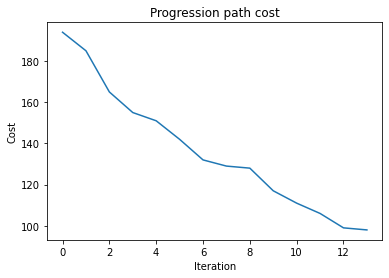

In [5]:
import numpy as np
import pandas as pd
from python_tsp.exact import solve_tsp_dynamic_programming
from python_tsp.heuristics import solve_tsp_local_search

def write_distance_matrix(n, mean, sigma):
    distance_matrix = np.zeros((n, n))
    random_distance = []
    num_distance = int(n * (n-1) / 2)
    for _ in range(num_distance):
        distance = 0
        while distance <= 0:
            distance = np.random.normal(mean, sigma)

        random_distance.append(round(distance))
    
    iu = np.triu_indices(n, 1)
    distance_matrix[iu] = random_distance
    distance_matrix += distance_matrix.T

    return distance_matrix
    

mean = 10
sigma = 10
N = 18
start = [0]
distance_matrix = pd.DataFrame(write_distance_matrix(N, mean, sigma))

path, dist = DFS(distance_matrix, start, heuristic = "Cluster", n_clusters = 3)

permutation, distance = solve_tsp_dynamic_programming(distance_matrix.to_numpy())
#solve_tsp_local_search #heuristic, approx
#solve_tsp_dynamic_programming #optimal
print("Ours vs optimal", dist, distance )

In [3]:
import numpy as np
import random 
import pandas as pd
import matplotlib.pyplot as plt

def SA_TS(dist_mat, max_iter, alpha, X_0, reheat_threshold, start_city = 0):
    
    # dist_mat: nxn symmetric numpy array 
    # max_iter: stopping criteria
    # alpha: geometric temperature scalar - a function of max_iter, current iteration, and desired acceptance prob X_0
    # X_0: initial desired acceptance
    # start_city: default 0
    
    p_array = []
    distance_array = []
    temp_array = []
    swap_types = ['Swap 2', 'Insert', 'Swap Subroute', 'Invert']
    
    # Total distance for current path
    def objective_function(state):
        cost = 0
        for i in range(len(state) - 2):
            cost += dist_mat[state[i], state[i+1]]
        cost += dist_mat[state[-2],state[-1]] #correct
        return cost
    
    # construct initial path
    def init_path():
        # Initial path: 0 -> 1, 1 -> 2, ... N-1 -> N -> 0
        initial = [i for i in range(len(dist_mat))]
        initial.remove(start_city)
        initial.insert(0,start_city) # at position 0, insert start_city
        initial.append(start_city)
        return initial
    
    # Computing the Initial Temperature of Simulated Annealing, Walid 2003
    # idea: sample SS bad transitions and calculate the acceptance ratio for this sample: iteratively reduce T until desired prob X_0
    def init_temp(X_0):
        
        s_trials = 0
        E_after = []
        E_before = []
        
        SS = int(max_iter/3) # trains such that we get X_0 acceptance for the first 10% of runtime
        
        # generate SS random positive transitions
        current_sample_path = init_path()
        current_sample_distance = objective_function(current_sample_path)
        
        while s_trials < SS:
            
            new_sample_path = choose_apply_action(current_sample_path)
            new_sample_distance = objective_function(new_sample_path)
            E = current_sample_distance - new_sample_distance 

            if E < 0:
                E_before.append(current_sample_distance) #Emin
                E_after.append(new_sample_distance) #Emax
                s_trials += 1
                
                if np.random.binomial(1, X_0) == 1:
                    current_sample_distance = new_sample_distance
                    current_sample_path = new_sample_path
            else:
                current_sample_path = new_sample_path
                current_sample_distance = new_sample_distance
        
        # Iteratively adjust initial temperature until acceptance ratio (X_Tn) is approximately equal X_0
        start = True
        X_Tn = 0
        Tn = 10*len(dist_mat) # initial starting temperature (only need Tn > 1)
        
        while abs(X_Tn - X_0) > 0.01:     
            
            num = 0
            denom = 0
            # without this check we terminate on the first iteration
            if start == True:
                X_Tn = X_0
                start = False
                
            Tn = abs(Tn*(np.log(X_Tn)/np.log(X_0)))
            
            for i in range(SS):
                num += np.exp(-E_after[i]/Tn)
                denom += np.exp(-E_before[i]/Tn)
                
            X_Tn = num/denom
            
        return Tn
    
    # path changing actions (4)
    def switch_two(state):
        # ex: a,b = 2,5
        # [0, 1, 2, 3, 4, 5, 6, 0] -> [0, 1, 5, 3, 4, 2, 6,0]
        a = random.randint(1, len(state)-2)
        b = random.randint(1, len(state)-2)
        while b == a:
            b = random.randint(1, len(state)-2)
        state[a], state[b] = state[b], state[a]
        return state
    
    def invert_path_between(state):
        # ex: a,b = 2,5
        # [0, 1, 2, 3, 4, 5, 6, 0] -> [0, 1, 4, 3, 2, 5, 6, 0]
        a = random.randint(1, len(state)-2)
        b = random.randint(1, len(state)-2)
        while b == a:
            b = random.randint(1, len(state)-2)    
        if b < a:
            a,b = b,a   
        state[a:b] = state[a:b][::-1] # reverse sublist
        return state

    def insert_random(state):
        # ex: a,b = 2,5
        # [0, 1, 2, 3, 4, 5, 6, 0] -> [0, 1, 3, 4, 5, 2, 6, 0]
        a = random.randint(1, len(state)-2)
        b = random.randint(1, len(state)-2)
        while b == a:
            b = random.randint(1, len(state)-2)    
        city = state.pop(a)
        state.insert(b, city) 
        return state
    
    def swap_subroute(state):
        # move a whole subroute
        a = random.randint(1, len(state)-2)
        b = random.randint(1, len(state)-2)
        while b == a:
            b = random.randint(1, len(state)-2)  
        if b < a:
            a,b = b,a  
        subroute = state[a:b]
        state = [state[x] for x in range(len(state)-1) if state[x] not in subroute]
        c = random.randint(1, len(state)-1)
        state[c:c] = subroute
        state.append(state[0])
        return state
    
    # randomly choose and apply an action
    def choose_apply_action(path):
        
        random_type = random.choice(swap_types)

        if random_type == 'Swap 2':
            new_path = switch_two(path)
        elif random_type == 'Insert':
            new_path = insert_random(path)
        elif random_type == 'Swap Subroute':
            new_path = swap_subroute(path)
        elif random_type == 'Invert':
            new_path = invert_path_between(path)
        return new_path
    
    # first path and initializations
    
    T = init_temp(X_0)
    
    heat = 0
    stagnation = 0
    reheat = 1
    
    path = init_path()
    current_distance = objective_function(path)
    best_distance = current_distance
    best_path = path
    
    # begin algorithm            
    for t in range(max_iter):
        
        
        # find new path and path's distance
        new_path = choose_apply_action(path)
        new_distance = objective_function(new_path)
        E = current_distance - new_distance
            
        # always track best path     
        if new_distance < best_distance:
            best_distance = new_distance
            best_path = new_path
        
        heat += 1
        
        # new path is shorter
        if E > 0:
            current_distance = new_distance
            path = new_path
        
        else:
                            
            # temperature function and probability (most sensitive part of the algorithm)   
            temp = T*alpha**heat
            p = np.exp(E/temp)/(reheat**0.8) # penalize reheating
            
            # roll whether to keep longer new path anyway
            if np.random.binomial(1, p) == 1:
                current_distance = new_distance
                path = new_path
                stagnation = 0 
                
            # increase stagnation factor: the longer we go with no bad rolls the more stagnated we become
            else:
                
                stagnation += 1
                
                # reset temperature
                if stagnation >= reheat_threshold:
                    
                    heat = 100*reheat
                    reheat_threshold *= 1.1 # increase threshold such that reheats become rarer each time
                    stagnation = 0
                    reheat += 1


    return best_path, best_distance